# Início

## 1. Import de bibliotecas

In [11]:
import os
import kagglehub
from pathlib import Path
from collections import Counter
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
import gc
import pandas as pd

## 2. Baixar o dataset BRACOL (com anotações revisadas)

In [2]:
# Download latest version
path = kagglehub.dataset_download("jonatanfragoso/bracol-for-yolov8-detection")

print("Path to dataset files:", path)

100%|██████████| 320M/320M [01:38<00:00, 3.39MB/s] 

Extracting files...


Path to dataset files: C:\Users\fpf\.cache\kagglehub\datasets\jonatanfragoso\bracol-for-yolov8-detection\versions\6


In [ ]:
import shutil
import os
from pathlib import Path

# 1. O caminho que o kagglehub te deu
caminho_origem = r'C:\Users\fpf\.cache\kagglehub\datasets\jonatanfragoso\bracol-for-yolov8-detection\versions\6'

# 2. O nome da pasta de destino (no seu diretório atual)
caminho_destino = os.path.join(os.getcwd(), 'data')

# 3. Mover os arquivos
if os.path.exists(caminho_origem):
    shutil.move(caminho_origem, caminho_destino)
    print(f"✅ Sucesso! Os arquivos agora estão em: {caminho_destino}")
else:
    print("❌ O caminho de origem não foi encontrado.")

✅ Sucesso! Os arquivos agora estão em: c:\Users\fpf\Desktop\André Okimoto\NCIA-PROJETO-CAF-\dataset_bracol


In [4]:
# Criar um PATH para acessar os arquivos do dataset revisado
PATH = Path("data/BRACOL_REVIEWED_ANNOTATIONS/BRACOL_REVIEWED")

## 3. Analisando os dados

In [5]:
data_yaml = PATH / "data.yaml"
assert data_yaml.exists(), "❌ data.yaml não encontrado"

data_cfg = {}
with open(data_yaml, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        if ":" in line:
            k, v = line.split(":", 1)
            data_cfg[k.strip()] = v.strip()

nc = int(data_cfg["nc"])
names = eval(data_cfg["names"])

print("Número de classes:", nc)
print("Classes:", names)
print("Train:", data_cfg.get("train"))
print("Val:", data_cfg.get("val"))
print("Test:", data_cfg.get("test"))


Número de classes: 4
Classes: ['Cercospora', 'Miner', 'Phoma', 'Rust']
Train: ../train/images
Val: ../valid/images
Test: ../test/images


In [6]:
splits = ["train", "valid", "test"]
stats = {}
bbox_counter = Counter()
class_counter = Counter()

for split in splits:
    img_dir = PATH / split / "images"
    lbl_dir = PATH / split / "labels"

    images = list(img_dir.glob("*"))
    labels = list(lbl_dir.glob("*.txt"))

    stats[split] = {"images": len(images), "labels": len(labels)}

    for lbl in labels:
        for line in lbl.read_text().splitlines():
            if not line.strip():
                continue
            cls = int(line.split()[0])
            bbox_counter[split] += 1
            class_counter[(split, cls)] += 1

print("📊 Estatísticas:")
count_images = 0
count_labels = 0
for s in stats:
    print(s, stats[s])
    count_images += stats[s]['images']
    count_labels += stats[s]['labels']

print(f"-- TOTAL: Imagens: {count_images}, Labels: {count_labels}")

print("\n📦 BBoxes por split:", dict(bbox_counter))
print("\n🦠 Distribuição por classe:")
for split in splits:
    print(split, {names[c]: class_counter[(split, c)] for c in range(nc)})


📊 Estatísticas:
train {'images': 1213, 'labels': 1213}
valid {'images': 351, 'labels': 351}
test {'images': 180, 'labels': 180}
-- TOTAL: Imagens: 1744, Labels: 1744

📦 BBoxes por split: {'train': 5798, 'valid': 1580, 'test': 848}

🦠 Distribuição por classe:
train {'Cercospora': 133, 'Miner': 171, 'Phoma': 1310, 'Rust': 4184}
valid {'Cercospora': 39, 'Miner': 111, 'Phoma': 254, 'Rust': 1176}
test {'Cercospora': 29, 'Miner': 59, 'Phoma': 107, 'Rust': 653}


In [7]:
areas = []

for split in splits:
    for lbl in (PATH / split / "labels").glob("*.txt"):
        for line in lbl.read_text().splitlines():
            if not line.strip():
                continue
            _, _, _, w, h = map(float, line.split())
            areas.append(w * h)

areas = np.array(areas)

print("Total de bboxes:", len(areas))
print("Área — min | mediana | p95 | max:",
      areas.min(), np.median(areas), np.percentile(areas, 95), areas.max())

print("⚠️ Manchas pequenas → imgsz alto recomendado (≥768)")


Total de bboxes: 8226
Área — min | mediana | p95 | max: 8.511543273925782e-08 0.0018120115995407104 0.021382570266723633 0.129241943359375
⚠️ Manchas pequenas → imgsz alto recomendado (≥768)


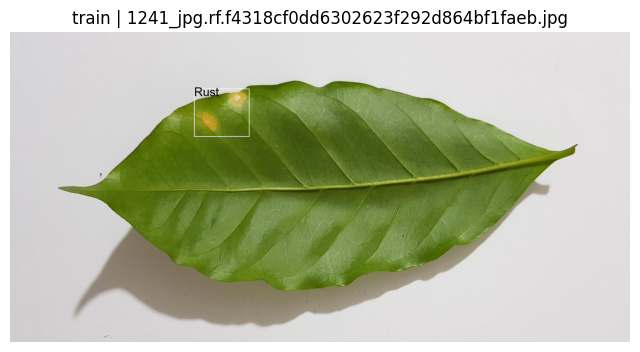

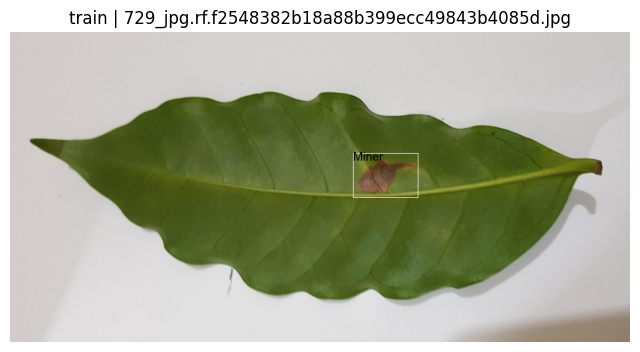

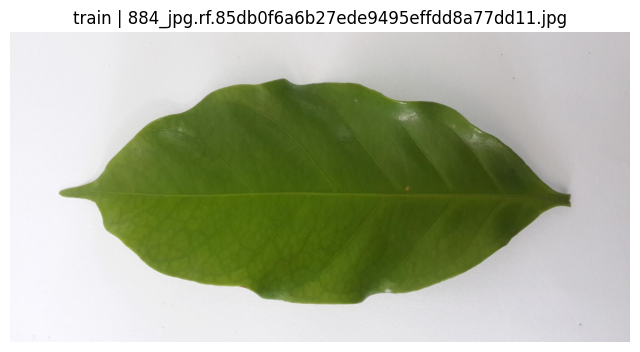

In [21]:
def yolo_to_xyxy(x, y, w, h, W, H):
    cx, cy = x * W, y * H
    bw, bh = w * W, h * H
    return int(cx - bw/2), int(cy - bh/2), int(cx + bw/2), int(cy + bh/2)

def show_samples(split="train", n=3):
    img_dir = PATH / split / "images"
    lbl_dir = PATH / split / "labels"

    imgs = list(img_dir.glob("*"))
    random.shuffle(imgs)

    for img_path in imgs[:n]:
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        W, H = img.size
        try:
            font = ImageFont.truetype("arial.ttf", 40) 
        except:
             # Caso não encontre a fonte, carrega a padrão (mas esta não permite mudar o tamanho)
            font = ImageFont.load_default()

        label_path = lbl_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            for line in label_path.read_text().splitlines():
                if not line.strip():
                    continue
                cls, x, y, w, h = map(float, line.split())
                x1, y1, x2, y2 = yolo_to_xyxy(x, y, w, h, W, H)
                draw.rectangle([x1, y1, x2, y2], outline="white", width=2)
                draw.text((x1, max(0, y1-12)), names[int(cls)], fill="black", font=font)

        plt.figure(figsize=(8,5))
        plt.title(f"{split} | {img_path.name}")
        plt.imshow(img)
        plt.axis("off")
        plt.show()

show_samples("train", 3)


# PDI

## 4. Testando segmentação por cores 

in progress...